In [2]:
import numpy as np
import pandas as pd
import os
import warnings

In [3]:
os.environ["OMP_NUM_THREADS"] = '1'
warnings.simplefilter(action='ignore', category=FutureWarning)

%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'retina'

In [31]:
water = pd.read_csv('C:/k_digital/source/data/data_city/data_tr_city.csv')

In [32]:
water['target'] = water['구미 혁신도시배수지 유출유량 적산차']
water = water.drop('구미 혁신도시배수지 유출유량 적산차', axis=1)

In [33]:
water['datetime'] = water['datetime'].astype('datetime64[ns]')

In [34]:
water = water.set_index('datetime')
water

,target
datetime,
2017-01-01 01:00:00,138.0
2017-01-01 02:00:00,237.0
2017-01-01 03:00:00,128.0
2017-01-01 04:00:00,14.0
2017-01-01 05:00:00,11.0
...,...
2020-12-31 19:00:00,328.0
2020-12-31 20:00:00,347.0
2020-12-31 21:00:00,335.0


In [35]:
water.index = water.index.to_period('h')

In [36]:
water.index

PeriodIndex(['2017-01-01 01:00', '2017-01-01 02:00', '2017-01-01 03:00',
             '2017-01-01 04:00', '2017-01-01 05:00', '2017-01-01 06:00',
             '2017-01-01 07:00', '2017-01-01 08:00', '2017-01-01 09:00',
             '2017-01-01 10:00',
             ...
             '2020-12-31 14:00', '2020-12-31 15:00', '2020-12-31 16:00',
             '2020-12-31 17:00', '2020-12-31 18:00', '2020-12-31 19:00',
             '2020-12-31 20:00', '2020-12-31 21:00', '2020-12-31 22:00',
             '2020-12-31 23:00'],
            dtype='period[H]', name='datetime', length=35063)

<AxesSubplot:xlabel='datetime'>

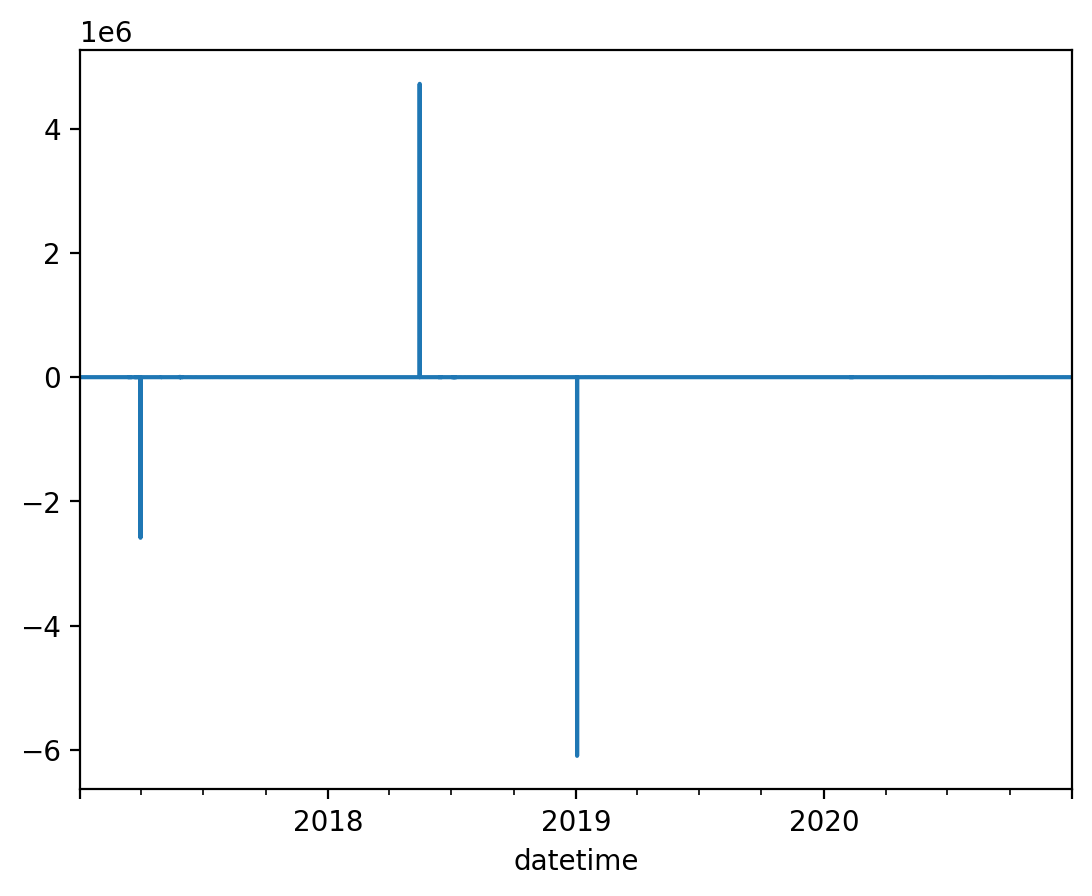

In [37]:
water.target.plot()

In [38]:
water.sort_values(by='target', ascending=False)

,target
datetime,
2018-05-15 20:00,4720655.0
2017-05-27 10:00,4999.0
2017-05-28 06:00,3357.0
2017-05-31 08:00,2591.0
2017-05-28 15:00,2550.0
...,...
2018-06-14 22:00,NaN
2018-07-04 12:00,NaN
2018-07-06 11:00,NaN


In [39]:
water.sort_values(by='target', ascending=True)

,target
datetime,
2019-01-02 15:00,-6093821.0
2017-03-30 16:00,-2584551.0
2017-05-25 18:00,0.0
2017-05-25 16:00,0.0
2017-05-25 14:00,0.0
...,...
2018-06-14 22:00,NaN
2018-07-04 12:00,NaN
2018-07-06 11:00,NaN


In [40]:
water.target = water.target.round(0)

In [41]:
water.target.replace(np.NaN, 0, inplace=True)

In [42]:
water[water.target == water.target.max()] = 0

In [43]:
for i in range(2):
    water[water.target == water.target.min()] = 0

<AxesSubplot:xlabel='datetime'>

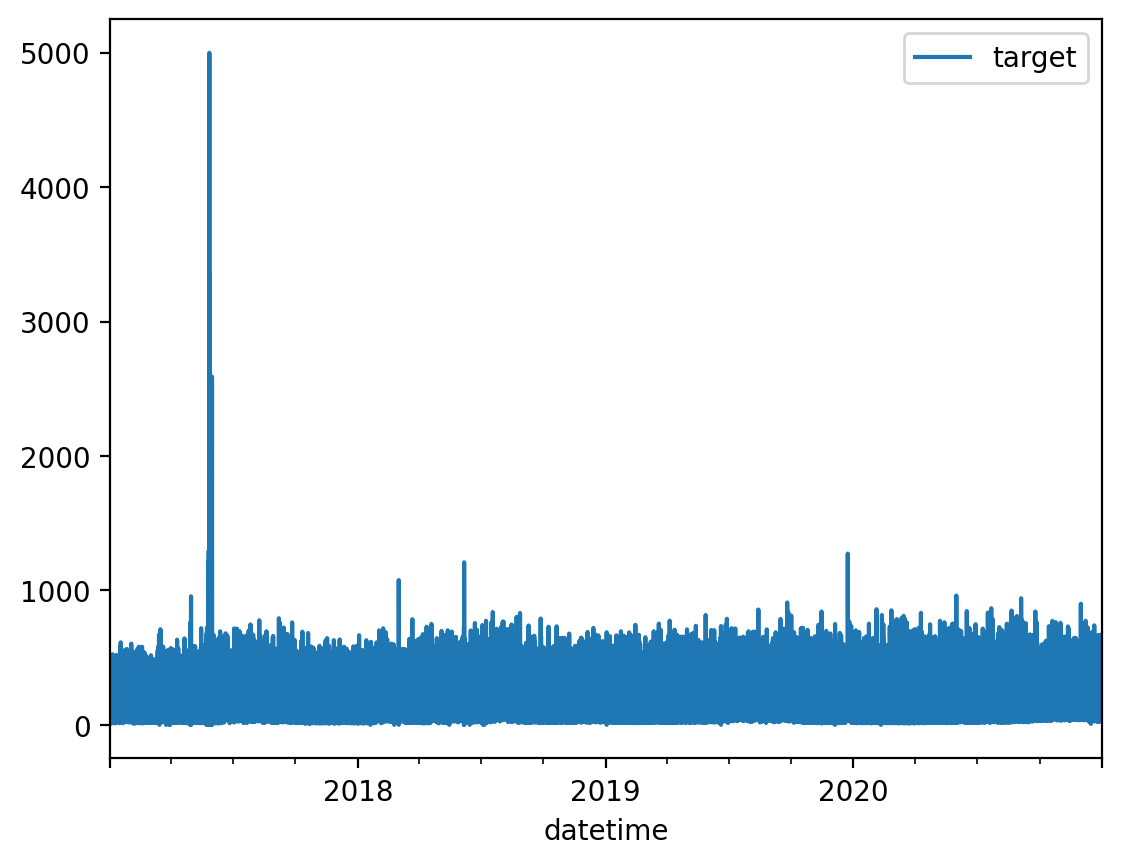

In [44]:
water.plot()

In [45]:
water[(water.index.year == 2017) & (water.index.month == 5) & (water.target == 0)]

,target
datetime,
2017-05-23 16:00,0.0
2017-05-23 18:00,0.0
2017-05-23 23:00,0.0
2017-05-24 21:00,0.0
2017-05-25 00:00,0.0
...,...
2017-05-31 03:00,0.0
2017-05-31 04:00,0.0
2017-05-31 05:00,0.0


### 5월 23, 24일 결측치처리 - 진행중

In [16]:
print(water[(water.index.year == 2017) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day <= 24) & (water.index.hour >= 14)])

                  target
datetime                
2017-05-23 14:00   684.0
2017-05-23 15:00   104.0
2017-05-23 16:00     0.0
2017-05-23 17:00   664.0
2017-05-23 18:00     0.0
2017-05-23 19:00   366.0
2017-05-23 20:00    56.0
2017-05-23 21:00   234.0
2017-05-23 22:00   486.0
2017-05-23 23:00     0.0
2017-05-24 14:00   303.0
2017-05-24 15:00   366.0
2017-05-24 16:00   154.0
2017-05-24 17:00   129.0
2017-05-24 18:00   171.0
2017-05-24 19:00   344.0
2017-05-24 20:00   175.0
2017-05-24 21:00     0.0
2017-05-24 22:00   670.0
2017-05-24 23:00   151.0


In [356]:
print(water[(water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (
    water.index.hour >= 15) & (water.index.hour <= 17)])

                  target
datetime                
2017-05-23 15:00   104.0
2017-05-23 16:00     0.0
2017-05-23 17:00   664.0
2018-05-23 15:00   227.0
2018-05-23 16:00   133.0
2018-05-23 17:00   402.0
2019-05-23 15:00    84.0
2019-05-23 16:00   228.0
2019-05-23 17:00   346.0
2020-05-23 15:00   456.0
2020-05-23 16:00   260.0
2020-05-23 17:00   147.0


In [ ]:
filled = water.target[(water.index.year == 2017) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (
    water.index.hour >= 15) & (water.index.hour <= 17)].sum()
fill = water.target[(water.index.year == 2019) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (
    water.index.hour >= 15) & (water.index.hour <= 17)].sum()

In [ ]:
print((filled / fill).round(2))

1.17


In [ ]:
water[water.index == '2017-05-23 16:00'] = water.target[water.index == '2019-05-23 16:00'] * 1.17
water[water.index == '2017-05-23 17:00'] = water.target[water.index == '2019-05-23 17:00'] * 1.17

In [ ]:
print(water[(water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (water.index.hour >= 17) & (water.index.hour <= 19)])

                  target
datetime                
2017-05-23 17:00  404.82
2017-05-23 18:00  158.76
2017-05-23 19:00  366.00
2018-05-23 17:00  402.00
2018-05-23 18:00  179.00
2018-05-23 19:00  369.00
2019-05-23 17:00  346.00
2019-05-23 18:00  145.00
2019-05-23 19:00  319.00
2020-05-23 17:00  147.00
2020-05-23 18:00  293.00
2020-05-23 19:00  520.00


In [69]:
filled = water.target[(water.index.year == 2017) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (
    water.index.hour > 17) & (water.index.hour < 19)].sum()
fill_1 = water.target[(water.index.year == 2018) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (
    water.index.hour > 17) & (water.index.hour < 19)].sum()
fill_2 = water.target[(water.index.year == 2019) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (
    water.index.hour > 17) & (water.index.hour < 19)].sum()

In [70]:
tot_fill = (fill_1+fill_2)/2
tot_fill = (filled/tot_fill).round(2)

In [229]:
(water.target[water.index == '2018-05-23 18:00'][0] + water.target[
    water.index == '2019-05-23 18:00'][0])/2

162.0

In [75]:
water[water.index == '2017-05-23 18:00'] = ((
    water.target[water.index == '2018-05-23 18:00'][0] + water.target[
        water.index == '2019-05-23 18:00'][0]) / 2) * 0.98

In [83]:
print(water[(water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (water.index.hour >= 22)])
print(water[(water.index.month == 5) & (
    water.index.day >= 24) & (water.index.day <= 24) & (water.index.hour <= 1)])

                  target
datetime                
2017-05-23 22:00   486.0
2017-05-23 23:00   519.4
2018-05-23 22:00   364.0
2018-05-23 23:00   490.0
2019-05-23 22:00   475.0
2019-05-23 23:00   459.0
2020-05-23 22:00   307.0
2020-05-23 23:00   132.0
                  target
datetime                
2017-05-24 00:00   249.1
2017-05-24 01:00   107.0
2018-05-24 00:00   235.0
2018-05-24 01:00   153.0
2019-05-24 00:00   390.0
2019-05-24 01:00   102.0
2020-05-24 00:00   198.0
2020-05-24 01:00   414.0


In [78]:
filled = (water.target[(water.index.year == 2017) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (
    water.index.hour >= 22)].sum() + water.target[
    (water.index.year == 2017) & (water.index.month == 5) & (
        water.index.day >= 24) & (water.index.day <= 24) & (
        water.index.hour <= 1)].sum())/2

In [79]:
fill = (water.target[(water.index.year == 2018) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day < 24) & (
    water.index.hour >= 22)].sum() + water.target[
    (water.index.year == 2018) & (water.index.month == 5) & (
        water.index.day >= 24) & (water.index.day <= 24) & (
        water.index.hour <= 1)].sum())/2

In [81]:
tot_fill = ((filled / fill).round(2))

In [82]:
water[water.index == '2017-05-23 23:00'] = water.target[water.index == '2018-05-23 23:00'] * tot_fill
water[water.index == '2017-05-24 00:00'] = water.target[water.index == '2018-05-24 00:00'] * tot_fill

In [87]:
print(water[(water.index.month == 5) & (
    water.index.day >= 24) & (water.index.day < 25) & (water.index.hour >= 20) & (water.index.hour <= 22)])

                  target
datetime                
2017-05-24 20:00   175.0
2017-05-24 21:00     NaN
2017-05-24 22:00   670.0
2018-05-24 20:00   341.0
2018-05-24 21:00   313.0
2018-05-24 22:00   190.0
2019-05-24 20:00   459.0
2019-05-24 21:00   204.0
2019-05-24 22:00   332.0
2020-05-24 20:00   415.0
2020-05-24 21:00   357.0
2020-05-24 22:00   437.0


<AxesSubplot:xlabel='datetime'>

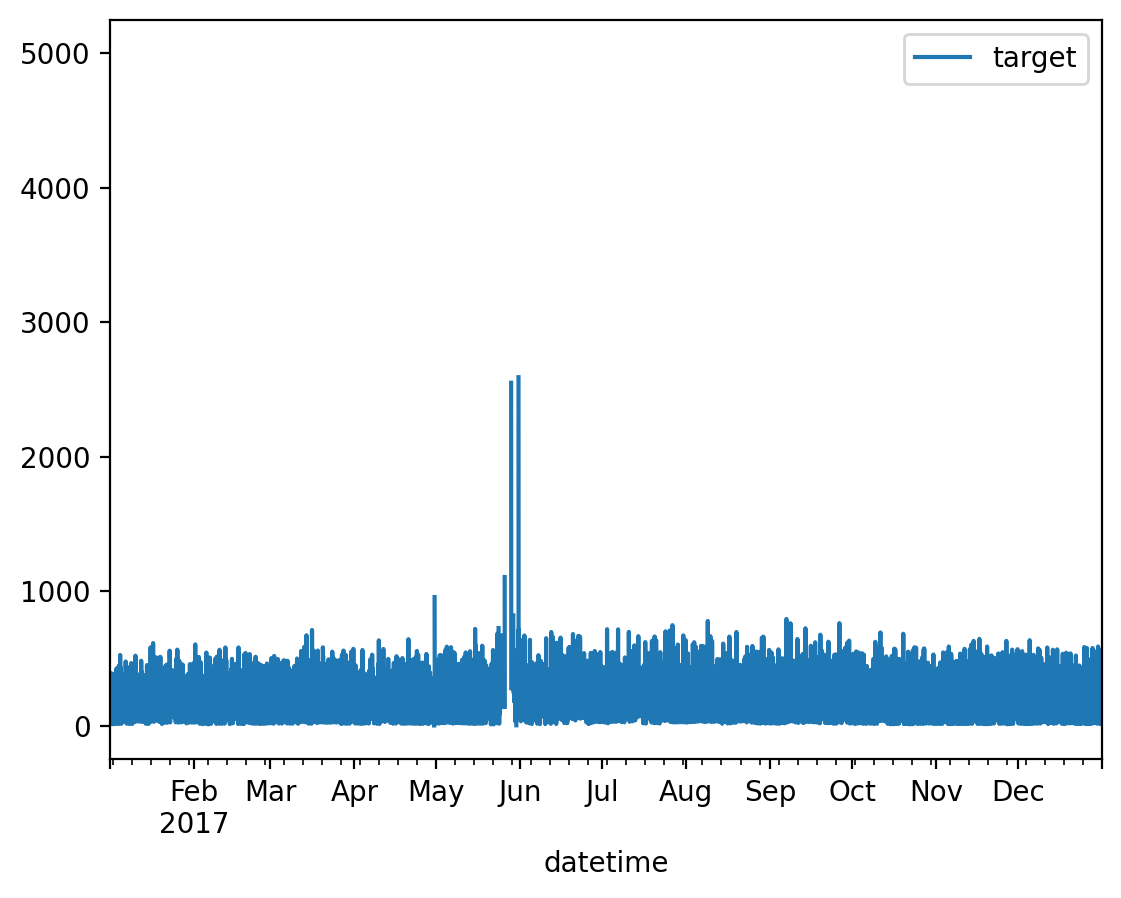

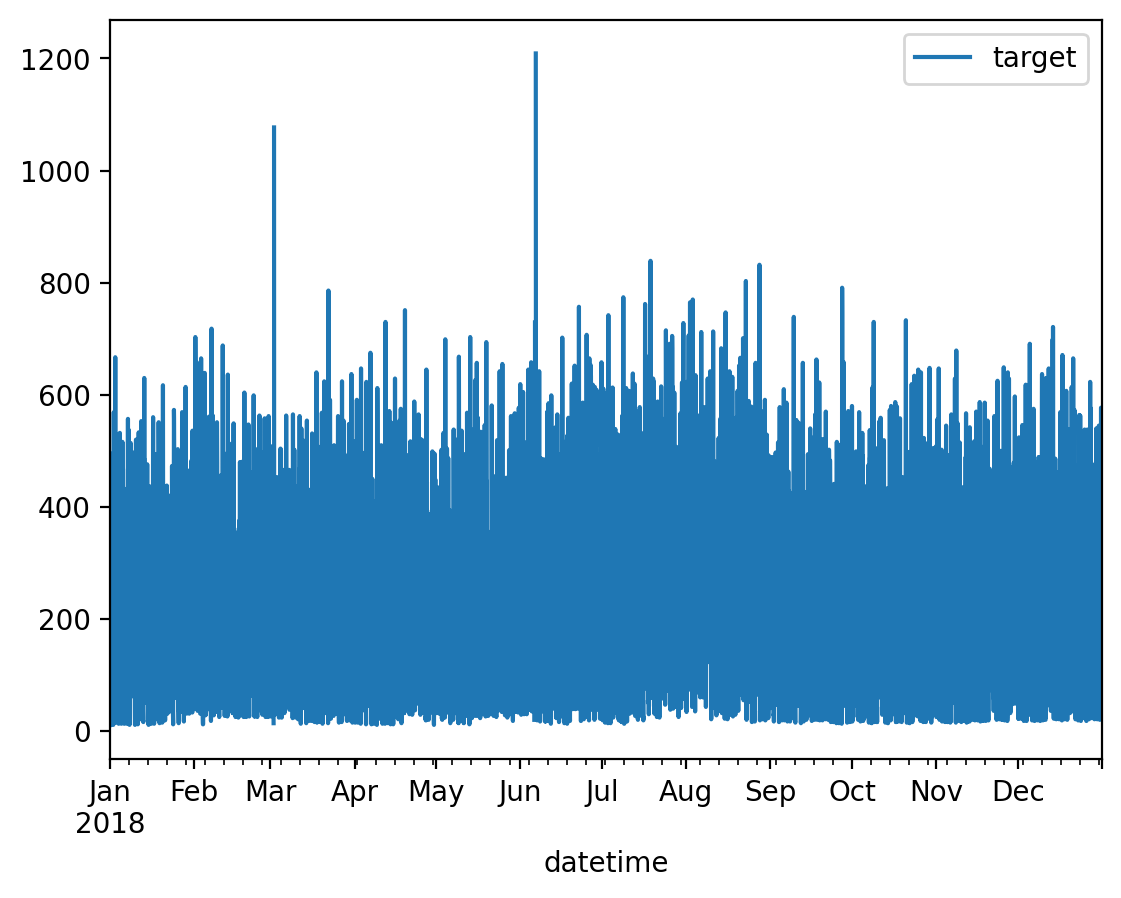

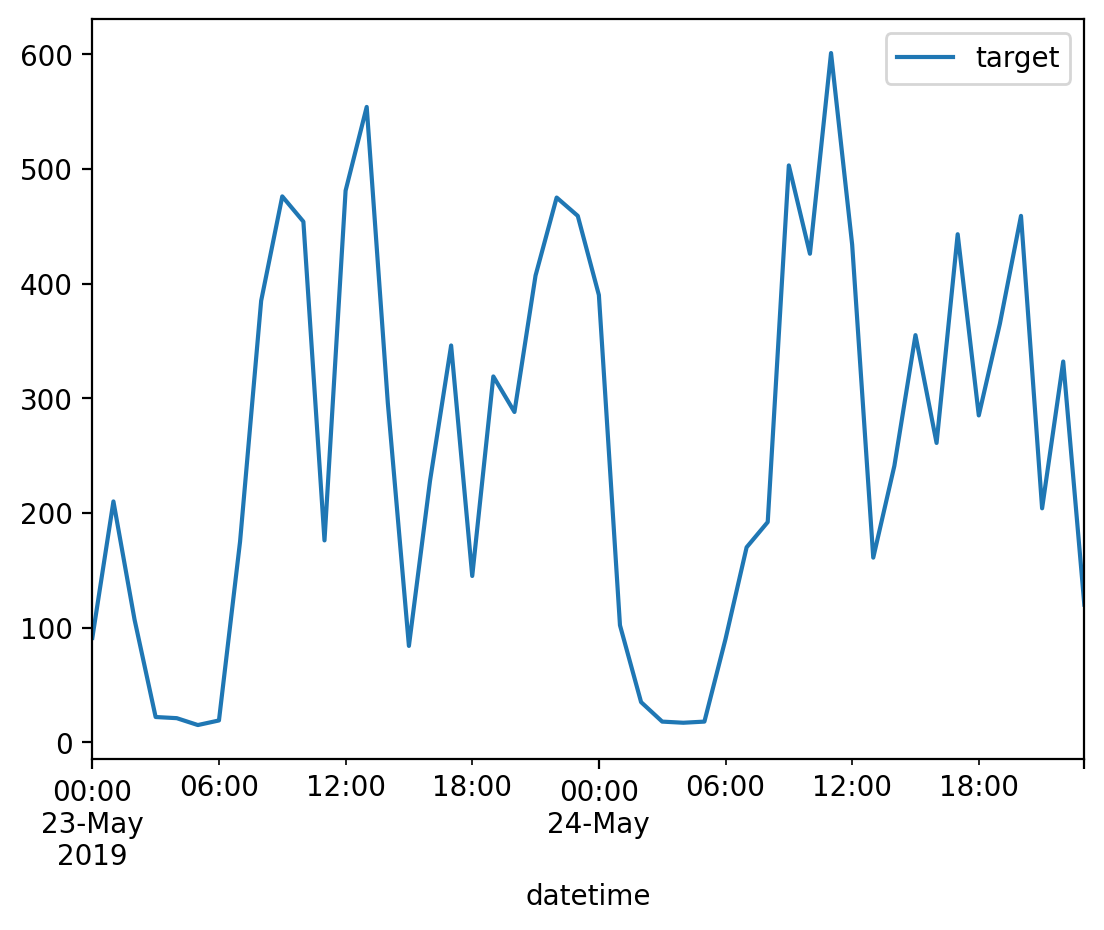

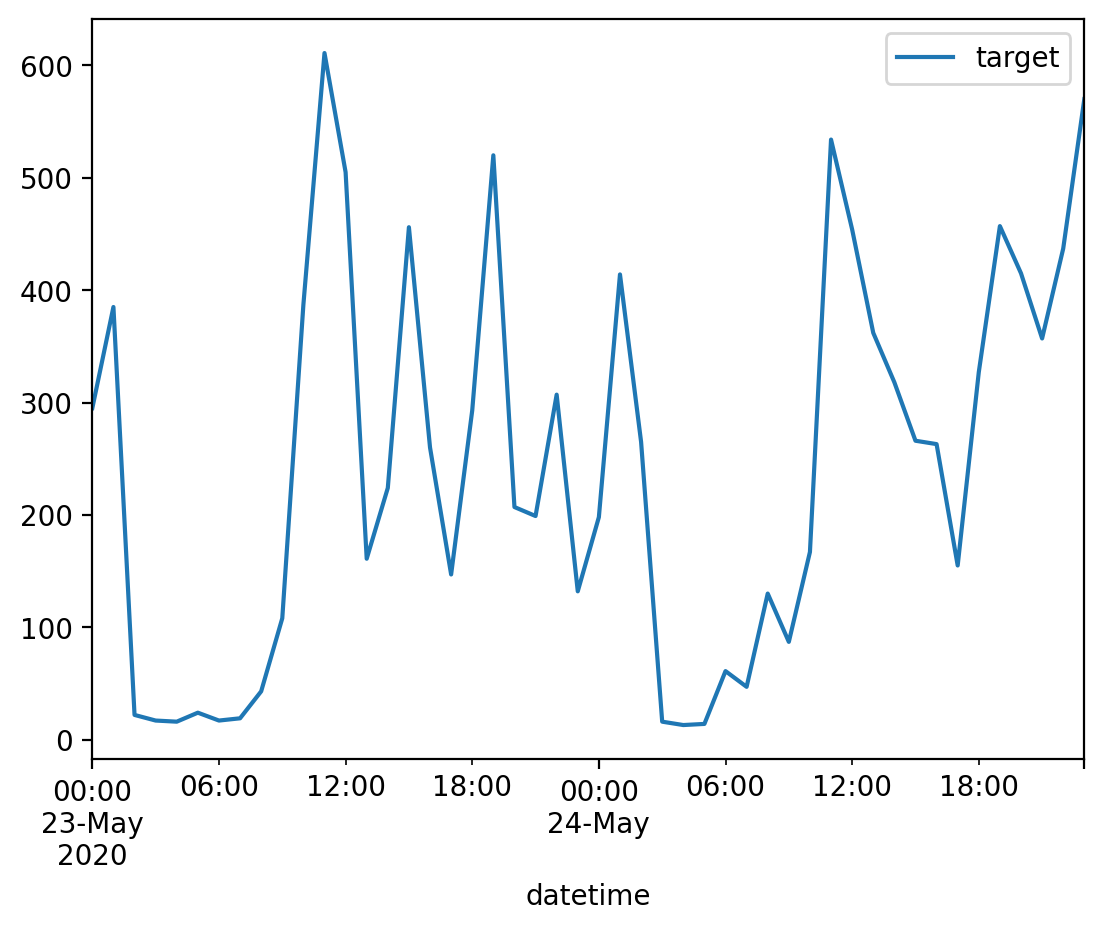

In [123]:
water[(water.index.year == 2017)].plot()
water[(water.index.year == 2018)].plot()
water[(water.index.year == 2019) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day <= 24)].plot()
water[(water.index.year == 2020) & (water.index.month == 5) & (
    water.index.day >= 23) & (water.index.day <= 24)].plot()

In [46]:
for i in range(4):
    print(water[(water.index.year == 2017+i) & (water.target == 0)])

                  target
datetime                
2017-03-14 21:00     0.0
2017-03-24 15:00     0.0
2017-03-28 17:00     0.0
2017-03-30 16:00     0.0
2017-04-29 14:00     0.0
...                  ...
2017-05-31 03:00     0.0
2017-05-31 04:00     0.0
2017-05-31 05:00     0.0
2017-05-31 06:00     0.0
2017-05-31 07:00     0.0

[127 rows x 1 columns]
                  target
datetime                
2018-01-19 15:00     0.0
2018-02-23 17:00     0.0
2018-03-02 06:00     0.0
2018-03-02 07:00     0.0
2018-03-02 08:00     0.0
2018-05-15 19:00     0.0
2018-05-15 20:00     0.0
2018-06-06 04:00     0.0
2018-06-06 05:00     0.0
2018-06-06 06:00     0.0
2018-06-06 07:00     0.0
2018-06-06 08:00     0.0
2018-06-06 12:00     0.0
2018-06-06 13:00     0.0
2018-06-06 14:00     0.0
2018-06-06 15:00     0.0
2018-06-14 21:00     0.0
2018-06-14 22:00     0.0
2018-07-04 12:00     0.0
2018-07-06 11:00     0.0
                  target
datetime                
2019-01-02 15:00     0.0
2019-06-19 20:00     0.0
2

In [47]:
water[water.target == 0].value_counts()

target
0.0       152
dtype: int64

In [48]:
def compare_time(*args):
    month, day, hour = args
    print(water[(water.index.month == month) & (water.index.day == day) & (
        water.index.hour >= hour-1) & (water.index.hour <= hour+1)])

In [49]:
# 0이 한개 또는 여러개 조건문
def replace_one(month, day, hour, *args):
    if len(args) == 2:
        a, b = args
        filled = water.target[(water.index.year == a) & (water.index.month == month) & (water.index.day >= day-1) & (
            water.index.day < day+1) & (water.index.hour >= hour-1) & (water.index.hour <= hour+1)].sum()
        fill = water.target[(water.index.year == b) & (water.index.month == month) & (water.index.day >= day-1) & (
            water.index.day < day+1) & (water.index.hour >= hour-1) & (water.index.hour <= hour+1)].sum()
        a_result = '{}-{}-{} {}:00'.format(a, month, day, hour)
        b_result = '{}-{}-{} {}:00'.format(b, month, day, hour)
        a_plus = '{}-{}-{} {}:00'.format(a, month, day, hour+1)
        b_plus = '{}-{}-{} {}:00'.format(b, month, day, hour+1)
        tot_fill = ((filled / fill).round(2))
        water[water.index == a_result] = (water.target[water.index == b_result] * tot_fill).round(2)
        water[water.index == a_plus] = (water.target[water.index == b_plus] * tot_fill).round(2)
    elif len(args) == 3:
        a, b, c = args
        filled = water.target[(water.index.year == a) & (water.index.month == month) & (water.index.day >= day-1) & (
            water.index.day < day+1) & (water.index.hour >= hour-1) & (water.index.hour <= hour+1)].sum()
        fill_1 = water.target[(water.index.year == b) & (water.index.month == month) & (water.index.day >= day-1) & (
            water.index.day < day+1) & (water.index.hour >= hour-1) & (water.index.hour <= hour+1)].sum()
        fill_2 = water.target[(water.index.year == c) & (water.index.month == month) & (water.index.day >= day-1) & (
            water.index.day < day+1) & (water.index.hour >= hour-1) & (water.index.hour <= hour+1)].sum()
        a_result = '{}-{}-{} {}:00'.format(a, month, day, hour)
        b_result = '{}-{}-{} {}:00'.format(b, month, day, hour)
        c_result = '{}-{}-{} {}:00'.format(c, month, day, hour)
        a_plus = '{}-{}-{} {}:00'.format(a, month, day, hour+1)
        b_plus = '{}-{}-{} {}:00'.format(b, month, day, hour+1)
        c_plus = '{}-{}-{} {}:00'.format(c, month, day, hour+1)
        tot_fill = (fill_1+fill_2)/2
        tot_fill = (filled/tot_fill).round(2)
        water[water.index == a_result] = (((water.target[water.index == b_result][0] + water.target[
            water.index ==  c_result][0]) / 2) * tot_fill).round(2)
        water[water.index == a_plus] = (((water.target[water.index == b_plus][0] + water.target[
            water.index ==  c_plus][0]) / 2) * tot_fill).round(2)
    else:
        a, b, c, d = args
        filled = water.target[(water.index.year == a) & (water.index.month == month) & (water.index.day >= day-1) & (
            water.index.day < day+1) & (water.index.hour >= hour-1) & (water.index.hour <= hour+1)].sum()
        fill_1 = water.target[(water.index.year == b) & (water.index.month == month) & (water.index.day >= day-1) & (
            water.index.day < day+1) & (water.index.hour >= hour-1) & (water.index.hour <= hour+1)].sum()
        fill_2 = water.target[(water.index.year == c) & (water.index.month == month) & (water.index.day >= day-1) & (
            water.index.day < day+1) & (water.index.hour >= hour-1) & (water.index.hour <= hour+1)].sum()
        fill_3 = water.target[(water.index.year == d) & (water.index.month == month) & (water.index.day >= day-1) & (
            water.index.day < day+1) & (water.index.hour >= hour-1) & (water.index.hour <= hour+1)].sum()
        a_result = '{}-{}-{} {}:00'.format(a, month, day, hour)
        b_result = '{}-{}-{} {}:00'.format(b, month, day, hour)
        c_result = '{}-{}-{} {}:00'.format(c, month, day, hour)
        d_result = '{}-{}-{} {}:00'.format(d, month, day, hour)
        a_plus = '{}-{}-{} {}:00'.format(a, month, day, hour+1)
        b_plus = '{}-{}-{} {}:00'.format(b, month, day, hour+1)
        c_plus = '{}-{}-{} {}:00'.format(c, month, day, hour+1)
        d_plus = '{}-{}-{} {}:00'.format(d, month, day, hour+1)
        tot_fill = (fill_1+fill_2+fill_3)/3
        tot_fill = (filled/tot_fill).round(2)
        water[water.index == a_result] = (((water.target[water.index == b_result][0] + water.target[
            water.index == c_result][0] + (water.target[water.index == d_result][0]) / 3)) * tot_fill).round(2)
        water[water.index == a_plus] = (((water.target[water.index == b_plus][0] + water.target[
            water.index == c_plus][0] + (water.target[water.index == d_plus][0]) / 3)) * tot_fill).round(2)

In [50]:
def replace_more(year, month, day, hour):
    i = 1
    count = 1
    fill_tot = 0
    filled_tot = 0
    tot_list = []
    df = pd.DataFrame(tot_list)
    find = water[water.index == '{}-{}-{} {}:00'.format(year, month, day, hour)]  # 입력값
    while True:
        if water.target[(find.index - i)[0]] != 0:
            # print(water.target[(find.index-i)[0]])  # 어디서 멈추는지 확인
            break
        else:
            count += 1
            i += 1
            # print(count)  # 값 확인
    # count 갯수만큼 다른 년도의 같은 시간대 불러오기(월, 일 동일)
    for i in water.index.year.unique().difference([year]):
        # print(i)  # 작동확인
        for j in range(count):
            # print((water[(water.index.year == i) & (water.index.month == month) & (
            #     water.index.day == day) & (water.index.hour == hour)].index-j)[0])  # 값 제대로 추출하는지 확인
    # 불러온뒤 평균 구하기
            fill_tot += water[water.index == (water.target[(water.index.year == i) & (water.index.month == month) & (
                water.index.day == day) & (water.index.hour == hour)].index-j)[0]].target[0]
            # print(fill_tot)  # 작동확인
    fill = (fill_tot/3).round(2)
    # print(fill)  # 작동확인
    # 원하는 년도와 다른 년도의 평균의 비율을 구함
    for i in range(count):
        filled_tot += water[water.index == (water.target[(water.index.year == year) & (
            water.index.month == month) & (water.index.day == day) & (water.index.hour == hour)].index-i)[0]].target[0]
        # print(filled_tot)  # 값확인
    rate = filled_tot / fill
    rate = rate.round(2)
    # print(rate)  # 값 확인
    # 각 행의 평균에 비율을 곱해서 결측치 채우기
    for i in water.index.year.unique().difference([year]):
        for j in range(count):
            tot_list.append((water.target[water.index == (water[(water.index.year == i) & (water.index.month == month) & (
                water.index.day == day) & (water.index.hour == hour)].index-j)[0]])[0])
        df[i]= tot_list[0:count]
        # print(df)  # 값 확인
        tot_list.clear()
    np_df = np.array(df)
    for i in range(count):
        water[water.index == (water[(water.index.year == year) & (water.index.month == month) & (
            water.index.day == day) & (water.index.hour == hour)].index-i)[0]] = (np_df[i].sum()/3*rate).round(2)

In [51]:
replace_one(3, 14, 21, 2017, 2018)

In [52]:
replace_one(3, 24, 15, 2017, 2019)

In [53]:
replace_one(3, 28, 17, 2017, 2018)

In [54]:
replace_one(3, 30, 16, 2017, 2020)

In [55]:
replace_one(4, 29, 14, 2017, 2018)

In [56]:
replace_more(2020, 2, 10, 16)

In [57]:
replace_one(12, 4, 19, 2019, 2020)

In [58]:
replace_one(6, 19, 20, 2019, 2020)

In [59]:
replace_one(1, 2, 15, 2019, 2018)

In [60]:
replace_one(7, 6, 11, 2018, 2017, 2019, 2020)

In [61]:
replace_one(7, 4, 12, 2018, 2017, 2019, 2020)

In [62]:
replace_more(2018, 6, 14, 23)

In [63]:
replace_more(2018, 6, 6, 16)

In [64]:
replace_more(2018, 6, 6, 9)

In [65]:
replace_more(2018, 5, 15, 21)

In [66]:
replace_more(2018, 3, 2, 9)

In [67]:
replace_one(2, 23, 17, 2018, 2020)

In [68]:
replace_one(1, 19, 15, 2018, 2020)

In [69]:
replace_more(2017, 5, 31, 8)

In [70]:
replace_more(2017, 5, 30, 18)

In [71]:
replace_more(2017, 5, 29, 10)

In [72]:
replace_more(2017, 5, 29, 3)

In [73]:
replace_more(2017, 5, 28, 19)

In [74]:
replace_more(2017, 5, 28, 15)

In [75]:
replace_more(2017, 5, 28, 6)

In [76]:
replace_more(2017, 5, 27, 10)

In [77]:
replace_more(2017, 5, 26, 12)

In [78]:
replace_more(2017, 5, 26, 6)

In [79]:
replace_one(5, 25, 21, 2017, 2019)

In [80]:
replace_more(2017, 5, 25, 20)

In [81]:
replace_one(5, 25, 16, 2017, 2019, 2020)

In [82]:
replace_more(2017, 4, 30, 6)

In [83]:
replace_more(2017, 4, 30, 11)

In [84]:
replace_more(2017, 5, 25, 13)

In [85]:
replace_one(5, 25, 14, 2017, 2019, 2020)

In [86]:
replace_one(5, 23, 16, 2017, 2019)

In [87]:
replace_one(5, 23, 18, 2017, 2018, 2019)

In [88]:
replace_one(5, 23, 23, 2017, 2018)

In [89]:
replace_one(5, 24, 21, 2017, 2018, 2019, 2020)

In [90]:
replace_one(5, 25, 0, 2017, 2018)

In [91]:
replace_one(5, 25, 2, 2017, 2018, 2019, 2020)

In [92]:
replace_one(5, 25, 4, 2017, 2018, 2019)

In [93]:
replace_one(5, 25, 6, 2017, 2019, 2020)

In [94]:
replace_one(5, 25, 7, 2017, 2019, 2020)

In [95]:
water[water.target == 0]

,target
datetime,


In [96]:
water.to_csv('water_preprocessing.csv')

In [2]:
water = pd.read_csv('water_preprocessing.csv')